<a href="https://colab.research.google.com/github/shinobu9/econometrica/blob/main/sem_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Установка библиотек

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.stats.stattools as stat

!pip install pymannkendall
import pymannkendall as mk

!pip install pandas_market_calendars
import pandas_market_calendars as mcal
from scipy import stats

from datetime import datetime
import matplotlib.dates as mdates

from matplotlib import pyplot as plt
%matplotlib inline

## Работа с данными

Данные могут прийти в любом виде. Например, данные по индексу Доу-Джонса за период с 28 февраля по 31 декабря 1984 года пришли без указания дат и в непривычном формате:

In [ ]:
data = pd.read_stata('dj_1984_daily.dta')
data.head()

,dj,dj_ret
0,1157.140015,NaN
1,1154.630005,-0.002171
2,1159.439941,0.004157
3,1171.479980,0.010331
4,1165.199951,-0.005375


Для корректной работы с временными рядами создадим столбец в формате datetime:

In [ ]:
data['date'] = pd.date_range(start = '1984-02-28', periods=len(data), freq='1D')
data

,dj,dj_ret,date
0,1157.140015,NaN,1984-02-28
1,1154.630005,-0.002171,1984-02-29
2,1159.439941,0.004157,1984-03-01
3,1171.479980,0.010331,1984-03-02
4,1165.199951,-0.005375,1984-03-03
...,...,...,...
209,1210.140015,0.009265,1984-09-24
210,1208.920044,-0.001009,1984-09-25
211,1202.520020,-0.005308,1984-09-26
212,1204.170044,0.001371,1984-09-27


Всё ли в порядке? 

Данные нам дали финансовые, а биржи закрыты по выходным и праздничным дням, для них нужны специальные календари. Нопример, из пакета pandas_market_calendars.

Запрашиваем календарь нью-йоркской биржи на нужные даты (посмотреть имена бирж можно с помощью команды print(mcal.get_calendar_names()):

In [ ]:
print(mcal.get_calendar_names())

['ASX', 'BMF', 'B3', 'CFE', 'CBOE_Futures', 'CBOE_Equity_Options', 'CBOE_Index_Options', 'CME_Equity', 'CBOT_Equity', 'CME_Agriculture', 'CBOT_Agriculture', 'COMEX_Agriculture', 'NYMEX_Agriculture', 'CME_Rate', 'CBOT_Rate', 'CME_InterestRate', 'CBOT_InterestRate', 'CME_Bond', 'CBOT_Bond', 'CMEGlobex_Livestock', 'CMEGlobex_Live_Cattle', 'CMEGlobex_Feeder_Cattle', 'CMEGlobex_Lean_Hog', 'CMEGlobex_Port_Cutout', 'CMEGlobex_FX', 'CME_FX', 'CME_Currency', 'CMEGlobex_EnergyAndMetals', 'CMEGlobex_Energy', 'CMEGlobex_CrudeAndRefined', 'CMEGlobex_NYHarbor', 'CMEGlobex_HO', 'HO', 'CMEGlobex_Crude', 'CMEGlobex_CL', 'CL', 'CMEGlobex_Gas', 'CMEGlobex_RB', 'RB', 'CMEGlobex_MicroCrude', 'CMEGlobex_MCL', 'MCL', 'CMEGlobex_NatGas', 'CMEGlobex_NG', 'NG', 'CMEGlobex_Dutch_NatGas', 'CMEGlobex_TTF', 'TTF', 'CMEGlobex_LastDay_NatGas', 'CMEGlobex_NN', 'NN', 'CMEGlobex_CarbonOffset', 'CMEGlobex_CGO', 'CGO', 'C-GEO', 'CMEGlobex_NGO', 'NGO', 'CMEGlobex_GEO', 'GEO', 'CMEGlobex_Metals', 'CMEGlobex_PreciousMetals',

In [ ]:
trad_dat = mcal.get_calendar('NYSE').schedule(start_date = '1984-02-28', end_date = '1984-12-31')
dates = mcal.date_range(trad_dat, frequency='1D')
data['date'] = dates
data

,dj,dj_ret,date
0,1157.140015,NaN,1984-02-28 21:00:00+00:00
1,1154.630005,-0.002171,1984-02-29 21:00:00+00:00
2,1159.439941,0.004157,1984-03-01 21:00:00+00:00
3,1171.479980,0.010331,1984-03-02 21:00:00+00:00
4,1165.199951,-0.005375,1984-03-05 21:00:00+00:00
...,...,...,...
209,1210.140015,0.009265,1984-12-24 21:00:00+00:00
210,1208.920044,-0.001009,1984-12-26 21:00:00+00:00
211,1202.520020,-0.005308,1984-12-27 21:00:00+00:00
212,1204.170044,0.001371,1984-12-28 21:00:00+00:00


Полезно посмотреть на график временного ряда. Не забывайте подписывать график и оси!

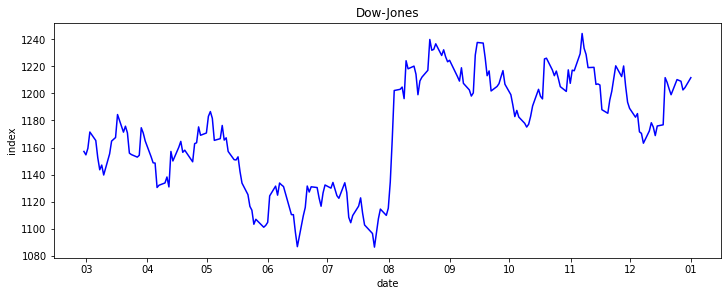

In [ ]:
fig, ax = plt.subplots(figsize=(10, 4), constrained_layout=True)

ax.set(title='Dow-Jones')
ax.plot(data['date'], data['dj'],'b-')
ax.xaxis_date()
ax.set_xlabel('date')
ax.set_ylabel('index')

ax.xaxis.set_major_formatter(mdates.DateFormatter("%m"))

plt.show()

## ЛР1 Проверка гипотезы случайности

Правда ли наблюдения взяты из случайной выборки (H0) или в данных есть тренд или какая-то другая закономерность?

## Задача 1 Проверка гипотезы случайности: непараметрические критерии. 

В файле dj_1897_1913 приведены годовые данные о значениях индекса Доу-Джонса за период с 1897 по 1913 г.г. 

Считайте файл и выведите первые пять значений в таблице

In [ ]:
data = pd.read_csv('dj_1897_1913.csv', sep = ';')

In [ ]:
data.head(5)

,dj,year
0,45.5,1897
1,52.8,1898
2,71.6,1899
3,61.4,1900
4,69.9,1901


Определите количество наблюдений в выборке. Для удобства разметим данные как годовые. 

Иногда команда to_datetime() не справляюется с разметкой данных и требуется указать формат в стиле %Y-%m-%d. Попробуйте запустить код ниже без указания формата

In [ ]:
data['year'] = pd.to_datetime(data['year'], format = '%Y')
#data['year'] = pd.to_datetime(data['year'])
data.head()

,dj,year
0,45.5,1897-01-01
1,52.8,1898-01-01
2,71.6,1899-01-01
3,61.4,1900-01-01
4,69.9,1901-01-01


### 1.1 Посмотрите на график этого ряда. 
Согласились ли бы Вы с утверждением о том, что это реализация случайной выборки?

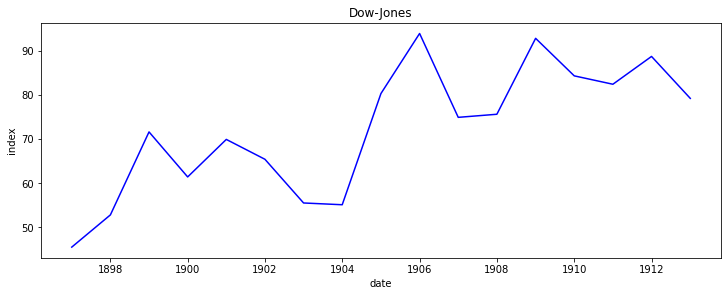

In [ ]:
fig, ax = plt.subplots(figsize=(10, 4), constrained_layout=True)

ax.set(title='Dow-Jones')
ax.plot(data['year'], data['dj'],'b-')
ax.xaxis_date()
ax.set_xlabel('date')
ax.set_ylabel('index')

ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

plt.show()

### 1.2 Критерий поворотных точек

Проверьте гипотезу случайности для ряда этих значений, применяя критерий поворотных точек с непосредственным вычислением статистики этого теста на основании визуального анализа графика ряда.

Сколько пиков наблюдается? Сколько впадин? Сколько поворотных точек?

Вычислите статистику критерия поворотных точек

In [ ]:
n = len(data['year'])
picks = 5
bottoms = 4
s = picks + bottoms

print(n, picks, bottoms, s)

17 5 4 9


In [ ]:
E_s = (n - 2) * 2 / 3
D_s = (16 * n - 29) / 90
S_stat = (s - E_s) / np.sqrt(D_s)

print(round(E_s, 3), round(D_s, 3), round(S_stat, 3))

10.0 2.7 -0.609


Сформулируйте нулевую гипотезу и проверьте, отвергается ли она

H0: случайный процесс
HA: неслучайный процесс

Так как статистика из стандартного нормального распределения, то, так как статистика по модулю меньше 1.96, то гипотеза не отвергается

### 1.3 Логарифмическая доходность

Постройте аналогичный график для логаримфической доходности индекса Доу-Джонса (определяемой как изменение логарифма индекса от года к году)

Создайте столбцы логарифма индекса и логарифмической доходности (разницы между соседними значениями ряда логарифмов)


In [ ]:
data['log_dj'] = np.log(data['dj'])
data['dj_ret'] = data['log_dj'].diff(1)

Выведите первые 5 значений таблицы

In [ ]:
data.head(5)

,dj,year,log_dj,dj_ret
0,45.5,1897-01-01,3.817712,NaN
1,52.8,1898-01-01,3.966511,0.148799
2,71.6,1899-01-01,4.271095,0.304584
3,61.4,1900-01-01,4.117410,-0.153685
4,69.9,1901-01-01,4.247066,0.129656


Постройте график логарифмической доходности

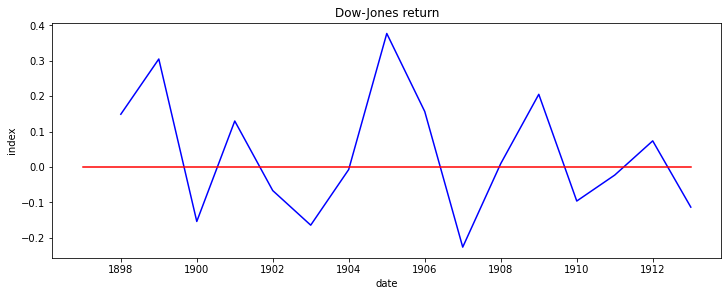

In [ ]:
fig, ax = plt.subplots(figsize=(10, 4), constrained_layout=True)

ax.set(title='Dow-Jones return')
ax.plot(data['year'], data['dj_ret'],'b-')
ax.plot(data['year'], np.zeros(len(data['year'])),'r-')
ax.xaxis_date()
ax.set_xlabel('date')
ax.set_ylabel('index')

ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

plt.show()

Вычислите статистику критерия поворотных точек

In [ ]:
n = len(data['dj_ret']) - 1
picks = 5
bottoms = 4
s = picks + bottoms

print(n, picks, bottoms, s)

16 5 4 9


In [ ]:
E_s = (n - 2) * 2 / 3
D_s = (16 * n - 29) / 90
S_stat = (s - E_s) / np.sqrt(D_s)

print(round(E_s, 3), round(D_s, 3), round(S_stat, 3))

9.333 2.522 -0.21


### 1.4 Критерий поворотных точек

Сравните полученные результаты с результатами приведенного алгоритма для рядов индекса и логарифмической доходности

In [ ]:
def turning_points_test(p):
    tp = []
    pcks = 0
    btms = 0
    for i in range(1, len(p)-1):
        if((p[i] < p[i+1]) and (p[i] < p[i-1])):
            pcks += 1
            tp.append(i)
        elif ((p[i] > p[i+1]) and (p[i] > p[i-1])):
            btms += 1
            tp.append(i)
    
    n = sum(~np.isnan(p))
    E_s = (n - 2) * 2 / 3
    D_s = (16 * n - 29) / 90
    S_stat = (pcks + btms - E_s) / np.sqrt(D_s)

    #tp, pcks, btms, round(E_s, 3), round(D_s, 3), round(S_stat, 3)

    print(' # наблюдений =', p.count(),
      '\n пики =', pcks,
      '\n впадины =', btms, 
      '\n поворотные точки =', len(tp),
      '\n среднее', round(E_s, 3),
      '\n дисперсия', round(D_s, 3),
      '\n статистика', round(S_stat, 3))

In [ ]:
turning_points_test(data['dj'])

 # наблюдений = 17 
 пики = 4 
 впадины = 5 
 поворотные точки = 9 
 среднее 10.0 
 дисперсия 2.7 
 статистика -0.609


In [ ]:
turning_points_test(data['dj_ret'])

 # наблюдений = 16 
 пики = 4 
 впадины = 5 
 поворотные точки = 9 
 среднее 9.333 
 дисперсия 2.522 
 статистика -0.21


### 1.5 Критерий Кендалла

Проверьте те же гипотезы, применяя критерий Кендалла. 

Для индекса:

In [ ]:
# trend, h, p, z, Tau, s, var_s, slope, intercept = mk.original_test(data)
results = mk.original_test(data['dj'])
results

Mann_Kendall_Test(trend='increasing', h=True, p=0.002637861089462845, z=3.0070618241864664, Tau=0.5441176470588235, s=74.0, var_s=589.3333333333334, slope=2.233333333333337, intercept=57.03333333333331)

In [ ]:
print(' p-value', round(results.p, 3),
      '\n тау Кендалла =', round(results.Tau, 3),
      '\n стандартизированная тау =', round(results.z, 3))

 p-value 0.003 
 тау Кендалла = 0.544 
 стандартизированная тау = 3.007


In [ ]:
results_ret = mk.original_test(data['dj_ret'])

print(' p-value', round(results_ret.p, 3),
      '\n тау Кендалла =', round(results_ret.Tau, 3),
      '\n стандартизированная тау =', round(results_ret.z, 3))

 p-value 0.499 
 тау Кендалла = -0.133 
 стандартизированная тау = -0.675


В случае обнаружения расхождений статистических выводов для критерия поворотных точек и критерия Кендалла, объясните, чем это может быть вызвано.

### 1.6 Критерий серий

Проверьте те же гипотезы, применяя критерий серий. Используйте соответствующую программу. Убедитесь, что программа правильно вычисляет количества плюсов и минусов и количества серий из плюсов и из минусов.

Создайте столбец отклонений индекса Доу-Джонса от медианы и изобразите на графике

In [ ]:
data['delta_dj'] = data['dj'] - data['dj'].median()

In [ ]:
data.head()

,dj,year,log_dj,dj_ret,delta_dj
0,45.5,1897-01-01,3.817712,NaN,-29.4
1,52.8,1898-01-01,3.966511,0.148799,-22.1
2,71.6,1899-01-01,4.271095,0.304584,-3.3
3,61.4,1900-01-01,4.117410,-0.153685,-13.5
4,69.9,1901-01-01,4.247066,0.129656,-5.0


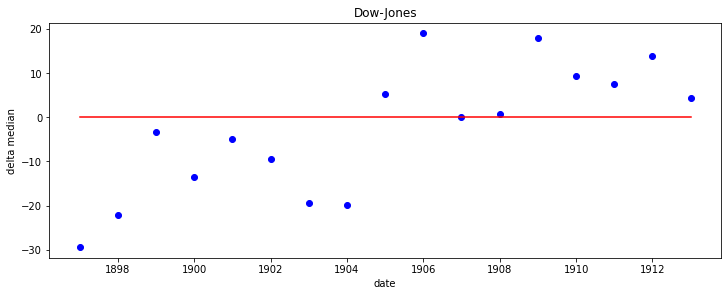

In [ ]:
fig, ax = plt.subplots(figsize=(10, 4), constrained_layout=True)

ax.set(title='Dow-Jones')
ax.plot(data['year'], data['delta_dj'],'bo')
ax.plot(data['year'], np.zeros(len(data['year'])),'r-')
ax.xaxis_date()
ax.set_xlabel('date')
ax.set_ylabel('delta median')

ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

plt.show()

Сколько плюсов, минусов и их серий видно на графике?

In [ ]:
pls = 8
mns = 9
s_pls = 2
s_mns = 2

Сформулируйте нулевую гипотезу и проверьте, отврегается ли она по критерию серий.

In [ ]:
def series_test(p):
    
    tst = 1
    plus = 0
    minus = 0
    
    if (p[0] > np.median(p)):
        plus += 1
    else:
        minus += 1
        
    for i in range(1, len(p)):
        if (p[i] <= np.median(p)):
            minus += 1
            if (p[i-1] > np.median(p)):
                tst += 1
        else:
            plus += 1
            if (p[i-1] <= np.median(p)):
                tst += 1
                
    n = plus + minus            
    e_s = 2 * plus * minus / n + 1
    d_s = 2 * plus * minus * (2 * plus * minus - n) / (n**2 * (n - 1))
    s_stat = (tst - e_s) / np.sqrt(d_s)
    #return plus, minus, tst, round(e_s, 3), round(d_s, 3), round(s_stat, 3)
    print(' плюсы =', plus,
      '\n минусы =', minus,
      '\n серии =', tst, 
      '\n среднее', round(e_s, 3),
      '\n дисперсия', round(d_s, 3),
      '\n статистика', round(s_stat, 3))

In [ ]:
series_test(data['dj'])

 плюсы = 8 
 минусы = 9 
 серии = 4 
 среднее 9.471 
 дисперсия 3.955 
 статистика -2.751


Проделайте аналогичную работу с рядом логарифмических доходностей

In [ ]:
data['delta_rdj'] =  data['dj_ret'] - data['dj_ret'].median()
data.head(5)

,dj,year,log_dj,dj_ret,delta_dj,delta_rdj
0,45.5,1897-01-01,3.817712,NaN,-29.4,NaN
1,52.8,1898-01-01,3.966511,0.148799,-22.1,0.147764
2,71.6,1899-01-01,4.271095,0.304584,-3.3,0.303549
3,61.4,1900-01-01,4.117410,-0.153685,-13.5,-0.154720
4,69.9,1901-01-01,4.247066,0.129656,-5.0,0.128621


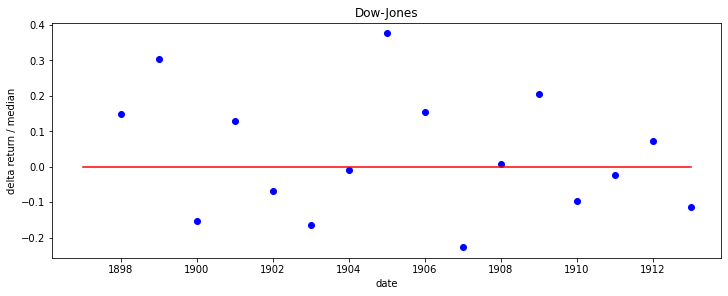

In [ ]:
fig, ax = plt.subplots(figsize=(10, 4), constrained_layout=True)

ax.set(title='Dow-Jones')
ax.plot(data['year'], data['delta_rdj'],'bo')
ax.plot(data['year'], np.zeros(len(data['year'])),'r-')
ax.xaxis_date()
ax.set_xlabel('date')
ax.set_ylabel('delta return / median')

ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

plt.show()

In [ ]:
series_test(data['delta_rdj'].dropna().values)

 плюсы = 8 
 минусы = 8 
 серии = 10 
 среднее 9.0 
 дисперсия 3.733 
 статистика 0.518


Сформулируйте нулевую гипотезу и проверьте, отврегается ли она по критерию серий для ряда доходностей.

## Задача 2а

В файле dj_1984_daily приведены дневные данные по индексу Доу-Джонса за период с 28 февраля по 31 декабря 1984 года. 

In [ ]:
data = pd.read_stata('dj_1984_daily.dta')

In [ ]:
data.head(5)

,dj,dj_ret
0,1157.140015,NaN
1,1154.630005,-0.002171
2,1159.439941,0.004157
3,1171.479980,0.010331
4,1165.199951,-0.005375


В соответствии с торговыми днями на американской бирже превратим данные во временные ряды

In [ ]:
trad_dat = mcal.get_calendar('NYSE').schedule(start_date = '1984-02-28', end_date = '1984-12-31')
dates = mcal.date_range(trad_dat, frequency='1D')
data['date'] = dates
data

,dj,dj_ret,date
0,1157.140015,NaN,1984-02-28 21:00:00+00:00
1,1154.630005,-0.002171,1984-02-29 21:00:00+00:00
2,1159.439941,0.004157,1984-03-01 21:00:00+00:00
3,1171.479980,0.010331,1984-03-02 21:00:00+00:00
4,1165.199951,-0.005375,1984-03-05 21:00:00+00:00
...,...,...,...
209,1210.140015,0.009265,1984-12-24 21:00:00+00:00
210,1208.920044,-0.001009,1984-12-26 21:00:00+00:00
211,1202.520020,-0.005308,1984-12-27 21:00:00+00:00
212,1204.170044,0.001371,1984-12-28 21:00:00+00:00


Изобразите графически дневной индекс

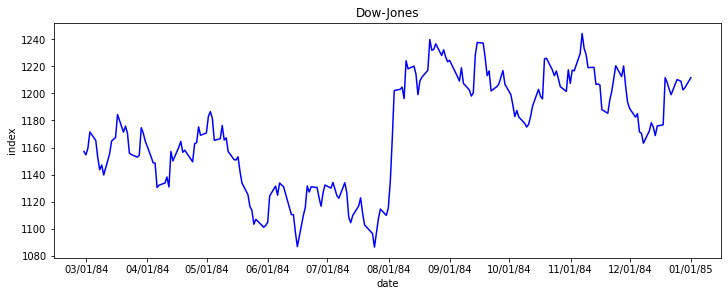

In [ ]:
fig, ax = plt.subplots(figsize=(10, 4), constrained_layout=True)

ax.set(title='Dow-Jones')
ax.plot(data['date'], data['dj'],'b-')
ax.xaxis_date()
ax.set_xlabel('date')
ax.set_ylabel('index')

ax.xaxis.set_major_formatter(mdates.DateFormatter("%D"))

plt.show()

Можно выделить две части ряда: с 28 февраля по 7 июля, с 6 августа по 31 декабря

In [ ]:
range_1 = (data['date'] >= '1984-02-28') & (data['date'] <= '1984-07-07')
range_2 = (data['date'] >= '1984-08-06') 

Разбейте датасет на два указанных периода.

На первом периоде имеется выраженная понижательная тенденция, которая может быть замечена критерием Кендалла. 

На втором периоде такой понижательной тенденции нет, поэтому здесь скорее подойдет критерий серий, обнаруживающий наличие автокоррелированности наблюдений.

In [ ]:
ts_1 = data[range_1]
ts_2 = data[range_2].reset_index()

Сначала рассмотрите период 28.02-7.06. Проверьте гипотезу случайности для ряда значений индекса на этом периоде, используя критерий Кендалла. 

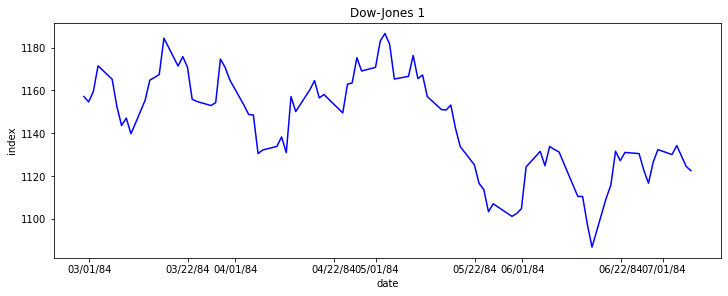

In [ ]:
fig, ax = plt.subplots(figsize=(10, 4), constrained_layout=True)

ax.set(title='Dow-Jones 1')
ax.plot(ts_1['date'], ts_1['dj'],'b-')
ax.xaxis_date()
ax.set_xlabel('date')
ax.set_ylabel('index')

ax.xaxis.set_major_formatter(mdates.DateFormatter("%D"))

plt.show()

In [ ]:
results = mk.original_test(ts_1['dj'])

print(' p-value', round(results.p, 3),
      '\n тау Кендалла =', round(results.Tau, 3),
      '\n стандартизированная тау =', round(results.z, 3))

 p-value 0.0 
 тау Кендалла = -0.416 
 стандартизированная тау = -5.835


Проверьте гипотезу случайности второго ряда, используя критерий серий

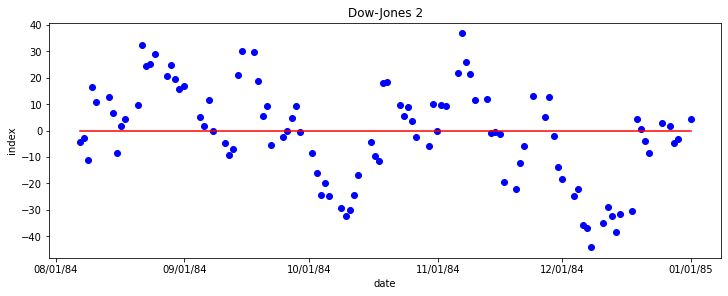

In [ ]:
ts_2['delta_dj'] = ts_2['dj'] - ts_2['dj'].median()
fig, ax = plt.subplots(figsize=(10, 4), constrained_layout=True)

ax.set(title='Dow-Jones 2')
ax.plot(ts_2['date'], ts_2['delta_dj'],'bo')
ax.plot(ts_2['date'], np.zeros(len(ts_2['date'])),'r-')
ax.xaxis_date()
ax.set_xlabel('date')
ax.set_ylabel('index')

ax.xaxis.set_major_formatter(mdates.DateFormatter("%D"))

plt.show()

In [ ]:
series_test(ts_2['dj'])

 плюсы = 50 
 минусы = 53 
 серии = 22 
 среднее 52.456 
 дисперсия 25.454 
 статистика -6.037


Отвергается ли гипотеза случайности?

Проверьте гипотезу случайности второго ряда, используя критерий поворотных точек

In [ ]:
turning_points_test(ts_2['dj'])

 # наблюдений = 103 
 пики = 26 
 впадины = 26 
 поворотные точки = 52 
 среднее 67.333 
 дисперсия 17.989 
 статистика -3.615


Отвергается ли гипотеза случайности?

## Задача 2б

Проверьте гипотезу случайности для ряда значений логарифмической доходности индекса, определяемой как изменение логарифма индекса от сессии к сессии:

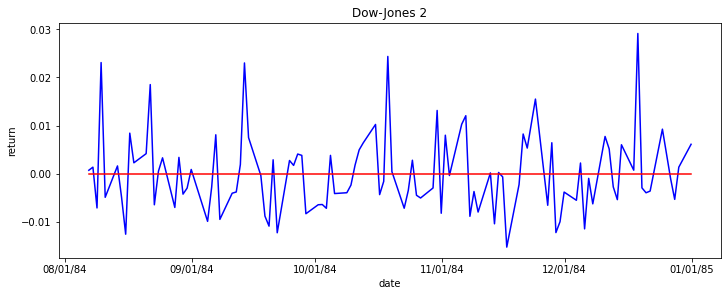

In [ ]:
fig, ax = plt.subplots(figsize=(10, 4), constrained_layout=True)

ax.set(title='Dow-Jones 2')
ax.plot(ts_2['date'], ts_2['dj_ret'],'b-')
ax.plot(ts_2['date'], np.zeros(len(ts_2['date'])),'r-')
ax.xaxis_date()
ax.set_xlabel('date')
ax.set_ylabel('return')

ax.xaxis.set_major_formatter(mdates.DateFormatter("%D"))

plt.show()

Проверьте гипотезу случайности, используя критерий серий и критерий поворотных точек.

In [ ]:
series_test(ts_2['dj_ret'])

 плюсы = 51 
 минусы = 52 
 серии = 51 
 среднее 52.495 
 дисперсия 25.493 
 статистика -0.296


In [ ]:
turning_points_test(ts_2['dj_ret'])

 # наблюдений = 103 
 пики = 34 
 впадины = 34 
 поворотные точки = 68 
 среднее 67.333 
 дисперсия 17.989 
 статистика 0.157


## Задача 3

В файле RTS_daily_518 приведены дневные данные по индексу РТС-1 за период с 9.10.1998 по 26.10.2000.

In [ ]:
data = pd.read_csv('rts1_daily_518.csv')

In [ ]:
data

,rts1
0,42.55
1,44.75
2,47.67
3,51.89
4,58.73
...,...
513,191.11
514,188.86
515,190.75
516,187.98


In [ ]:
trad_dat = mcal.get_calendar('XMOS').schedule(start_date = '1998-10-09', end_date = '2000-10-26')
dates = mcal.date_range(trad_dat, frequency='1D')
data['date'] = dates
data

,rts1,date
0,42.55,1998-10-09 14:45:00+00:00
1,44.75,1998-10-12 14:45:00+00:00
2,47.67,1998-10-13 14:45:00+00:00
3,51.89,1998-10-14 14:45:00+00:00
4,58.73,1998-10-15 14:45:00+00:00
...,...,...
513,191.11,2000-10-20 14:45:00+00:00
514,188.86,2000-10-23 14:45:00+00:00
515,190.75,2000-10-24 14:45:00+00:00
516,187.98,2000-10-25 14:45:00+00:00


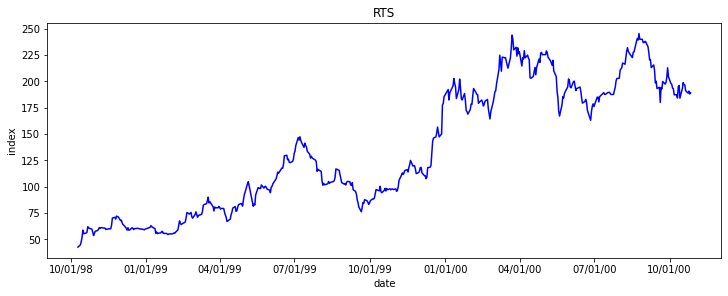

In [ ]:
fig, ax = plt.subplots(figsize=(10, 4), constrained_layout=True)

ax.set(title='RTS')
ax.plot(data['date'], data['rts1'], 'b-')
ax.xaxis_date()
ax.set_xlabel('date')
ax.set_ylabel('index')

ax.xaxis.set_major_formatter(mdates.DateFormatter("%D"))

plt.show()

Индекс РТС появился 1 сентября 1995 года и начал рассчитываться в долларах с отметки в 100 пунктов. Почему мы рассматриваем здесь динамику этого индекса не с этой даты?

Проверьте гипотезу случайности для ряда значений логарифмической доходности индекса, определяемой как изменение логарифма индекса от сессии к сессии:

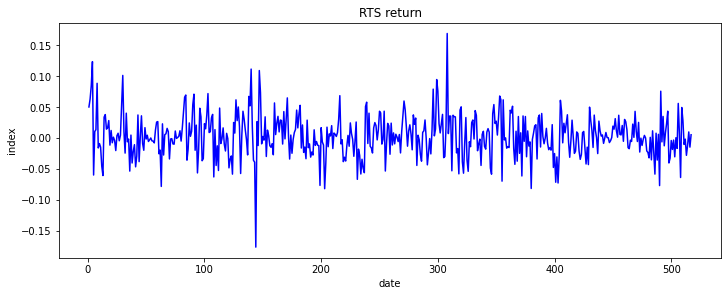

In [ ]:
data['rts_ret'] = np.log(data['rts1']).diff(1)

fig, ax = plt.subplots(figsize=(10, 4), constrained_layout=True)

ax.set(title='RTS return')
ax.plot(data['rts_ret'], 'b-')
#ax.xaxis_date()
ax.set_xlabel('date')
ax.set_ylabel('index')

#ax.xaxis.set_major_formatter(mdates.DateFormatter("%D"))

plt.show()

Используйте все три критерия для проверки случайности рядов

In [ ]:
turning_points_test(data['rts_ret'])

 # наблюдений = 517 
 пики = 171 
 впадины = 171 
 поворотные точки = 342 
 среднее 343.333 
 дисперсия 91.589 
 статистика -0.139


In [ ]:
results_ret = mk.original_test(data['rts_ret'])

print(' p-value', round(results_ret.p, 3),
      '\n тау Кендалла =', round(results_ret.Tau, 3),
      '\n стандартизированная тау =', round(results_ret.z, 3))

 p-value 0.271 
 тау Кендалла = -0.032 
 стандартизированная тау = -1.1


In [ ]:
series_test(data['rts_ret'].dropna().values)

 плюсы = 258 
 минусы = 259 
 серии = 225 
 среднее 259.499 
 дисперсия 128.999 
 статистика -3.037


Отвергается ли гипотеза случайности?

## Задача 4 Белый шум

Белый шум это случайный процес $wn_t$, обладающий свойствами:

$E(wn_t) = 0,$ 

$D(wn_t) = \sigma^2 > 0, $

$cov(wn_s, wn_t) = 0 \quad (s \neq t)$

Смоделируйте 4 реализации процесса гауссовского белого шума с единичной дисперсией. Постройте раздельные графики этих реализаций и объединенный график для всех четырех реализаций. 

In [ ]:
wn = []

for i in range(0, 4):
    wn.append(np.random.standard_normal(100))

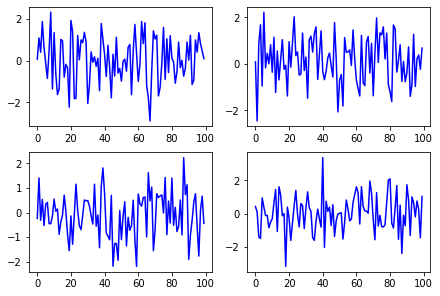

In [ ]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, constrained_layout=True)

i=0

for row in ax:
    for col in row:
        col.plot(wn[i], 'b-')
        i += 1

plt.show()

Является ли белый шум случайным процессом?

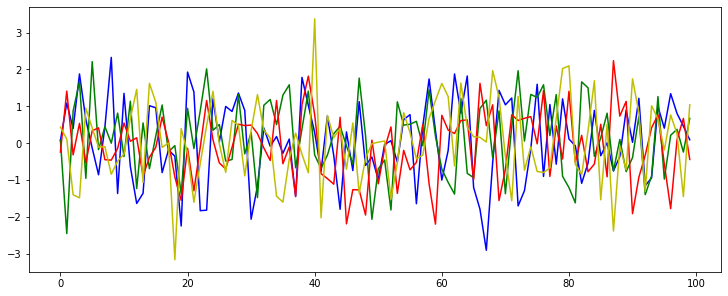

In [ ]:
fig, ax = plt.subplots(figsize = (10,4), constrained_layout=True)

ax.plot(wn[0], 'b-')
ax.plot(wn[1], 'g-')
ax.plot(wn[2], 'r-')
ax.plot(wn[3], 'y-')


plt.show()

Для каждой реализации проведите обычную диагностику остатков от оцененной регрессии реализации на константу. 

In [ ]:
# Return the jarque bera test statistics, pvalue, skewness, and the kurtosis.
stat.jarque_bera(wn[0])

(2.4819454132726726,
 0.2891028688470582,
 -0.24090203449026032,
 2.397064067832033)

In [ ]:
results = []
results.append('p-value')

for i in range(0, len(wn)):
    results.append(stat.jarque_bera(wn[i])[1])

In [ ]:
results